In [1]:
# Importing the required packages
import igraph as ig
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats

# Specifying the figure parameters
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 10,
          'legend.handlelength': 2.}
plt.rcParams.update(params)


In [2]:
def results(iters= 1,pop=10000,edge_per_node= 2,days=730,m=8, power = 1,immunity_length = 240,
            probs_inf=[0.01,0.01,0.1,0.2,0.3,0.3,0.3,0.25,0.2,0.15,0.1,0.05,0.01,0.01]):
    time_1perc_all = [] #time when 1% of the population is first infected
    wave2_time_1perc_all =[]
    wave3_time_1perc_all =[]
    tot_time_1perc_all = [] #total time for which 1% of the population is infected
    wave2_tot_time_1perc_all = []
    wave3_tot_time_1perc_all =[]
    peak_time_all = []
    wave2_peak_time_all = []
    wave3_peak_time_all = []
    peak_perc_all = []
    wave2_peak_perc_all =[]
    wave3_peak_perc_all =[]
    
    S_final = []
    R_final = []
    I_final = []
    T_final = []
    
    for i in range(0,iters):
        time_1perc = False
        wave2_time_1perc =False
        wave3_time_1perc =False
        tt = False
        wave2_tt =False
        wave3_tt =False
        tt_peak = False
        wave2_tt_peak =False
        wave3_tt_peak =False
        tot_time_1perc = 0.0
        wave2_tot_time_1perc =0.0
        wave3_tot_time_1perc =0.0
        I_stores = 0.0
        g = ig.Graph.Barabasi(pop, edge_per_node,power)
        g.vs["state"] = "S"
        g.vs["duration"] = 0
        g.vs["immune"] = 0
        i = rd.randint(0, pop-1)
        g.vs[i]["state"] = "I"
        for time in range(days): #no. of days
            
            if len(g.vs.select(state_eq = "I")) > pop*0.075 and time_1perc is False:
                #stores the time that 1% of the population is infected
                time_1perc = True
                tot_time_1perc = float(time)
                time_1perc_all.append(time)
                
            if len(g.vs.select(state_eq = "I")) > pop*0.075 and time>150 and time_1perc is True and wave2_time_1perc is False:
                #stores the time that 1% of the population is infected
                wave2_time_1perc = True
                wave2_tot_time_1perc = float(time)
                wave2_time_1perc_all.append(time)            
 
            if len(g.vs.select(state_eq = "I")) > pop*0.075 and time>250 and time_1perc is True and wave2_time_1perc is True and wave3_time_1perc is False:
                #stores the time that 1% of the population is infected
                wave3_time_1perc = True
                wave3_tot_time_1perc = float(time)
                wave3_time_1perc_all.append(time)   
                
            if len(g.vs.select(state_eq = "I")) < pop*0.075 and tot_time_1perc > 0.0 and tt is False:
                #stores the total time for which 1% of the population is infected
                tot_time = time - tot_time_1perc
                tot_time_1perc_all.append(tot_time)
                tt = True     
                
            if len(g.vs.select(state_eq = "I")) < pop*0.075 and wave2_tot_time_1perc > 0.0 and wave2_tt is False:
                wave2_tot_time = time - wave2_tot_time_1perc
                wave2_tot_time_1perc_all.append(wave2_tot_time)
                wave2_tt = True
                
            if len(g.vs.select(state_eq = "I")) < pop*0.075 and wave3_tot_time_1perc > 0.0 and wave3_tt is False:
                wave3_tot_time = time - wave3_tot_time_1perc
                wave3_tot_time_1perc_all.append(wave3_tot_time)
                wave3_tt = True

            for n in g.vs.select(state_eq = "I"): #iterates through each infected node in the network
                g.vs[n.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect
                day_inf = g.vs[n.index]["duration"]
                for nb in g.neighbors(n): #iterates through neighbours of that node
                    if g.vs[nb]["state"] == "S": #if node is infected...
                        r = rd.random() #random state
                        if r < probs_inf[day_inf]:
                            g.vs[nb]["state"] = "I" #change state to infected 
                    if g.vs[nb]["state"] == "T":
                        r0 = rd.random()
                        if r0 < 0.17:
                            r1 = rd.random()
                            if r1 < probs_inf[day_inf]:
                                g.vs[nb]["state"] = "I" #change state to infected 
                        
                if g.vs[n.index]["duration"] >= rd.randrange(2,14): #after infect_len that node changes to recovered
                    g.vs[n.index]["state"] = "T"
                    g.vs[n.index]["immune"] = g.vs[n.index]["duration"]#number of days of immunity starts
                    g.vs[n.index]["duration"] = 0
                    g.vs[n.index]["immune"] += 1
                     
            
            for n in g.vs.select(state_eq = "T"):
                g.vs[n.index]["immune"] += 1
                if g.vs[n.index]["immune"] == immunity_length:
                    g.vs[n.index]["state"] = "S" 
                    g.vs[n.index]["duration"] = 0
            
            
            S_final.append(len(g.vs.select(state_eq = "S")))
            I_final.append(len(g.vs.select(state_eq = "I")))
            R_final.append(len(g.vs.select(state_eq = "R")))
            T_final.append(len(g.vs.select(state_eq = "T")))

            if time_1perc is True and I_stores > len(g.vs.select(state_eq = "I")) and tt_peak is False:
                # if pop greater than 7.5% and previous no. of infected nodes is higher than current assume peak
                tt_peak = True
                peak_time_all.append(time)
                peak_perc_all.append(I_stores)

            if wave2_time_1perc is True and I_stores > len(g.vs.select(state_eq = "I")) and wave2_tt_peak is False:
                # if pop greater than 7.5% and previous no. of infected nodes is higher than current assume peak
                wave2_tt_peak = True
                wave2_peak_time_all.append(time)
                wave2_peak_perc_all.append(I_stores)

            if wave3_time_1perc is True and I_stores > len(g.vs.select(state_eq = "I")) and wave3_tt_peak is False:
                # if pop greater than 7.5% and previous no. of infected nodes is higher than current assume peak
                wave3_tt_peak = True
                wave3_peak_time_all.append(time)
                wave3_peak_perc_all.append(I_stores)
                
            I_stores = len(g.vs.select(state_eq = "I"))
            

            
            if days == 300:
                f = rd.randint(0, pop-1)
                if g.vs[f]["state"] == "S":
                    g.vs[f]["state"] = "I"

            if days == 600:
                f = rd.randint(0, pop-1)
                if g.vs[f]["state"] == "S":
                    g.vs[f]["state"] = "I"

            
    return(peak_time_all, peak_perc_all,tot_time_1perc_all, time_1perc_all,
           wave2_peak_time_all,wave2_peak_perc_all,wave2_tot_time_1perc_all,wave2_time_1perc_all,
           wave3_peak_time_all, wave3_peak_perc_all,wave3_tot_time_1perc_all,wave3_time_1perc_all,
           S_final, I_final, T_final) 
  
         


In [43]:
print(No_immunity[0])#wave1 peak
print(No_immunity[1])#number infected at wave1peak
--print(No_immunity[2])#length of wave1
print(No_immunity[3]) #day wave 1 started
print(No_immunity[4])#wave2peak
print(No_immunity[5]) #number infected at wave2peak
--print(No_immunity[6])#length of wave2
print(No_immunity[7])#day wave2 started
print(No_immunity[8])#wave3 peak
print(No_immunity[9])# number infected at wave3peak
--print(No_immunity[10])#length of wave3
print(No_immunity[11])#day wave3started

[25, 36, 23]
[4237, 4229, 4197]
[]
[16, 26, 14]
[151, 151, 152]
[3122, 3221, 3200]
[]
[151, 151, 151]
[454, 452, 452]
[3227, 3172, 3148]
[]
[451, 451, 451]


In [3]:
Five_months=results(iters=1, immunity_length=150)

In [4]:
Six_months=results(iters=1, immunity_length=180)

In [5]:
Seven_months=results(iters=1, immunity_length=210)

In [6]:
Eight_months=results(iters=1, immunity_length=240)

In [7]:
Nine_months=results(iters=1, immunity_length=270)

In [8]:
No_immunity=results(iters=1, immunity_length=15)

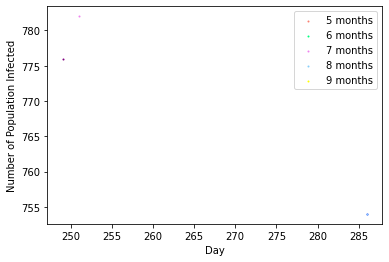

In [9]:
fig,ax1 = plt.subplots()

#ax1.scatter(No_immunity[0],No_immunity[1], s=1, color='black') #wave1
#ax1.scatter(No_immunity[4],No_immunity[5],s=1,color='black') #wave2
#ax1.scatter(No_immunity[8],No_immunity[9],s=1,color='black') #wave3

#ax1.scatter(Five_months[0],Five_months[1], label='5 months', s=1, color='red') #wave1
ax1.scatter(Five_months[4],Five_months[5],s=1,color='red') #wave2
ax1.scatter(Five_months[8],Five_months[9],label='5 months',s=1,color='salmon') #wave3

#ax1.scatter(Six_months[0],Six_months[1],label='6 months',s=1,color='green') #wave1
ax1.scatter(Six_months[4],Six_months[5],s=1,color='green') #wave2
ax1.scatter(Six_months[8],Six_months[9],label='6 months',s=1,color='springgreen') #wave3

#ax1.scatter(Seven_months[0],Seven_months[1],label='7 months',s=1,color='purple') #wave1
ax1.scatter(Seven_months[4],Seven_months[5],s=1,color='purple') #wave2
ax1.scatter(Seven_months[8],Seven_months[9],label='7 months',s=1,color='violet') #wave3

#ax1.scatter(Eight_months[0],Eight_months[1],label='8 months',s=1,color='blue') #wave1
ax1.scatter(Eight_months[4],Eight_months[5],s=1,color='blue') #wave2
ax1.scatter(Eight_months[8],Eight_months[9],label='8 months',s=1,color='lightskyblue') #wave3

#ax1.scatter(Nine_months[0],Nine_months[1],label='9 months',s=1,color='yellow') #wave1
ax1.scatter(Nine_months[4],Nine_months[5],s=1,color='yellow') #wave2
ax1.scatter(Nine_months[8],Nine_months[9],label='9 months',s=1,color='yellow') #wave3

ax1.set_ylabel('Number of Population Infected')
ax1.set_xlabel('Day')

ax1.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

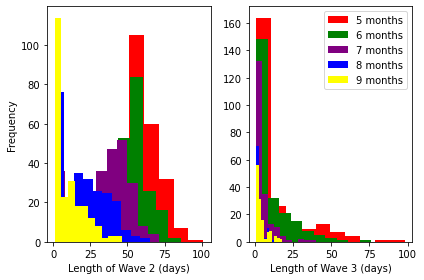

In [85]:
fig, (ax1,ax2)  = plt.subplots(1,2) #1=length of wave 2 2=length of wave 3
#plt.boxplot(No_immunity)

Label = ['5 months', '6 Months', '7 Months', '8 Months', '9 Months']

#ax1.hist(x= np.array(No_immunity[6]),histtype='step', color='black')
ax1.hist(x= np.array(Five_months[6]),label='5 months', color='red')
ax1.hist(x= np.array(Six_months[6]), label='6 months',color='green')
ax1.hist(x= np.array(Seven_months[6]),label='7 months', color='purple')
ax1.hist(x= np.array(Eight_months[6]), label='8 months',color='blue')
ax1.hist(x= np.array(Nine_months[6]), label='9 months',color='yellow')

#ax1.hist(x= np.array(No_immunity[10]),histtype='step', color='black')
ax2.hist(x= np.array(Five_months[10]),label='5 months', color='red')
ax2.hist(x= np.array(Six_months[10]), label='6 months',color='green')
ax2.hist(x= np.array(Seven_months[10]),label='7 months', color='purple')
ax2.hist(x= np.array(Eight_months[10]), label='8 months',color='blue')
ax2.hist(x= np.array(Nine_months[10]), label='9 months',color='yellow')

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Length of Wave 2 (days)')
ax2.set_xlabel('Length of Wave 3 (days)')
plt.tight_layout()
ax2.legend()
plt.show